In [17]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [18]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

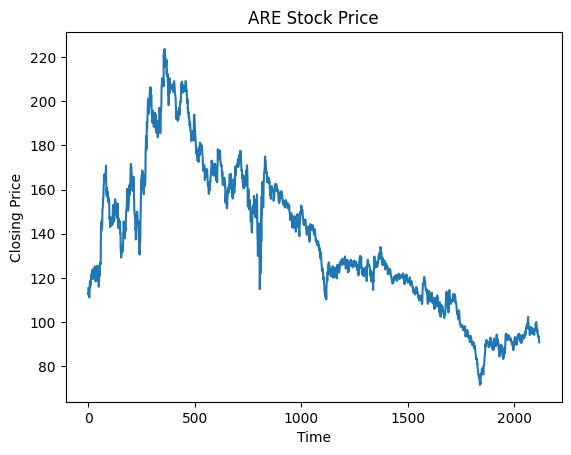

In [19]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [20]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [25]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 121ms/step - loss: 0.0673 - val_loss: 0.0136
Epoch 2/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0065 - val_loss: 0.0125
Epoch 3/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 5/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 9/100
22/22 [==============================] - 2s 93ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0017 - val_loss: 0.001

In [27]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 17ms/step


In [28]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [29]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 97.81674785584225
Testing RMSE: 102.43875328896678


In [30]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=152
i=0
while(i<30):
    
    if(len(temp_input)>152):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.13684834 0.13500527 0.13796735 0.13540021 0.13757241 0.14290416
 0.14836756 0.13862559 0.13790153 0.14441811 0.13816482 0.13816482
 0.13730911 0.13309637 0.14132438 0.13500527 0.13414955 0.13276725
 0.13665087 0.13052923 0.12921274 0.12644813 0.12506582 0.12131385
 0.12723802 0.12743549 0.11907583 0.11328331 0.1135466  0.10406793
 0.10327804 0.11203265 0.11367825 0.12203791 0.13145076 0.13724329
 0.14204845 0.14250922 0.13855977 0.13283307 0.1288178  0.12875197
 0.13329384 0.12269616 0.12012902 0.12486835 0.12065561 0.13151659
 0.13052923 0.1400079  0.14448394 0.13875724 0.14994734 0.15027646
 0.14270669 0.14369405 0.14540548 0.15126382 0.15060558 0.15060558
 0.14915745 0.14257504 0.13000263 0.13816482 0.13066087 0.14487888
 0.13368878 0.12414429 0.1269089  0.14244339 0.14303581 0.1364534
 0.1342812  0.14685361 0.14454976 0.14882833 0.14718273 0.14408899
 0.14566877 0.14060032 0.1397446  0.14158768 0.14125856 0.14435229
 0.14988152 0.15376514 0.14889415 0.16100579 0.1586

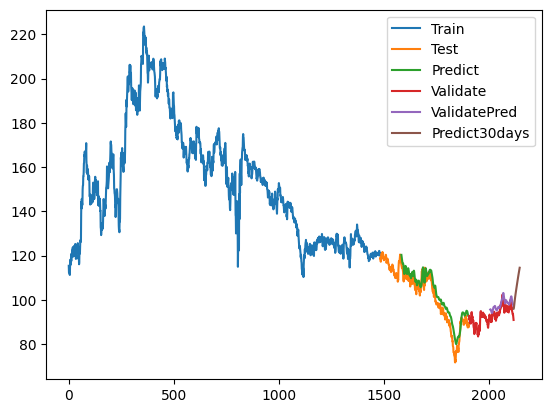

In [31]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [32]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [38]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 137ms/step - loss: 0.1382 - val_loss: 0.0209
Epoch 2/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 3/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 4/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0038 - val_loss: 8.8038e-04
Epoch 5/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0035 - val_loss: 9.1825e-04
Epoch 6/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0033 - val_loss: 8.9293e-04
Epoch 7/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0033 - val_loss: 9.2690e-04
Epoch 8/100
22/22 [==============================] - 2s 88ms/step - loss: 0.0029 - val_loss: 8.4087e-04
Epoch 9/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0027 - val_loss: 8.4920e-04
Epoch 10/100
22/22 [==============================] - 2s 89ms/step - loss: 

In [40]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 20ms/step


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [42]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 16.149450944659193
Testing RMSE: 15.729752747802504


In [43]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=152
i=0
while(i<30):
    
    if(len(temp_input)>152):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.83419689 0.82189119 0.81735751 0.81800518 0.81800518 0.82124352
 0.81994819 0.81865285 0.81282383 0.80310881 0.7888601  0.78756477
 0.78173575 0.79339378 0.81023316 0.80829016 0.81800518 0.8257772
 0.82512953 0.82772021 0.82836788 0.81994819 0.81994819 0.80634715
 0.81217617 0.81541451 0.81930052 0.79857513 0.80634715 0.78950777
 0.79274611 0.8134715  0.8503886  0.8503886  0.85556995 0.85751295
 0.8626943  0.84909326 0.84391192 0.83678756 0.82836788 0.83160622
 0.83290155 0.8257772  0.82318653 0.82707254 0.82966321 0.83743523
 0.84067358 0.85168394 0.8503886  0.83743523 0.84909326 0.8484456
 0.83354922 0.83937824 0.84196891 0.84650259 0.84909326 0.85168394
 0.85297927 0.84520725 0.82966321 0.83095855 0.82901554 0.83031088
 0.8257772  0.82642487 0.83743523 0.8380829  0.83678756 0.83225389
 0.83290155 0.84391192 0.84132124 0.84455959 0.84002591 0.82966321
 0.83290155 0.83225389 0.83290155 0.83290155 0.83678756 0.84455959
 0.84261658 0.84067358 0.8361399  0.84585492 0.84067

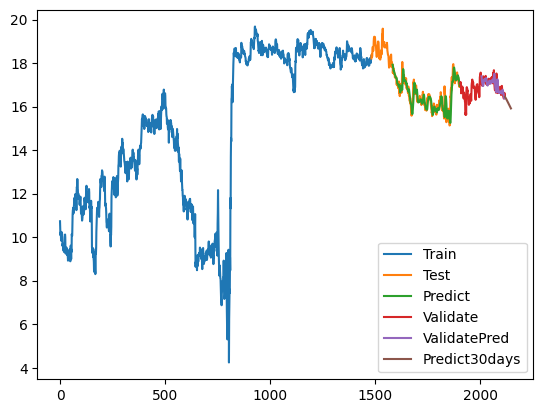

In [44]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [45]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

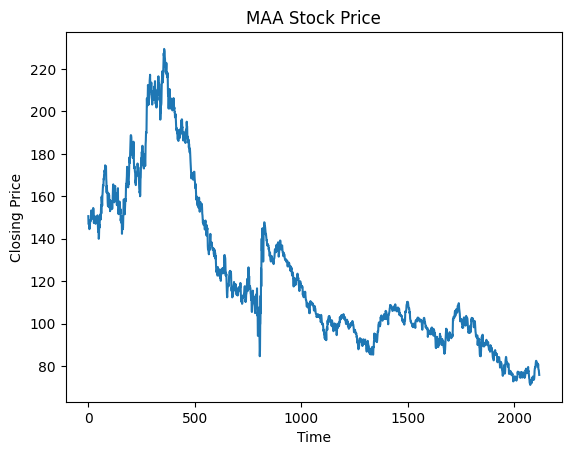

In [46]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [47]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [48]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [49]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [50]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [51]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [52]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [53]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 122ms/step - loss: 0.0326 - val_loss: 0.0075
Epoch 2/100
22/22 [==============================] - 2s 88ms/step - loss: 0.0031 - val_loss: 9.2961e-04
Epoch 3/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0018 - val_loss: 5.9727e-04
Epoch 4/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0017 - val_loss: 5.0765e-04
Epoch 5/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0017 - val_loss: 6.1705e-04
Epoch 6/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0017 - val_loss: 4.9060e-04
Epoch 7/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0015 - val_loss: 5.9650e-04
Epoch 8/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0015 - val_loss: 4.5496e-04
Epoch 9/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0014 - val_loss: 4.4193e-04
Epoch 10/100
22/22 [==============================] - 2s 90ms/step 

In [54]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 17ms/step


In [55]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [56]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 77.94883826989587
Testing RMSE: 95.44122976038001


In [57]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=152
i=0
while(i<30):
    
    if(len(temp_input)>152):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.066713   0.06330154 0.06349106 0.05938467 0.05401478 0.05862657
 0.06336471 0.05805799 0.0511719  0.03316697 0.0325984  0.03493588
 0.03525175 0.03582033 0.04131657 0.04188515 0.04131657 0.03733653
 0.03752606 0.03253522 0.03221934 0.02918694 0.03474635 0.03373555
 0.03026091 0.03354602 0.02842883 0.0267231  0.02274307 0.01048708
 0.01351949 0.01749953 0.01339314 0.0175627  0.0185735  0.02173226
 0.0254596  0.02527007 0.01787858 0.01844715 0.01535157 0.01939478
 0.0185735  0.01566745 0.01276139 0.01775223 0.02154274 0.02274307
 0.02173226 0.03165077 0.03929496 0.0331038  0.03904226 0.03752606
 0.03221934 0.03721018 0.0356308  0.03607303 0.03550445 0.03594668
 0.03600986 0.02969234 0.02110051 0.02842883 0.02741803 0.03784194
 0.03266157 0.02533325 0.02400657 0.03721018 0.03209299 0.02185861
 0.02880788 0.03518858 0.03443048 0.03525175 0.03733653 0.03424095
 0.02792343 0.02583865 0.02406975 0.02514372 0.02110051 0.02684945
 0.02299577 0.02855518 0.03108219 0.04422263 0.040

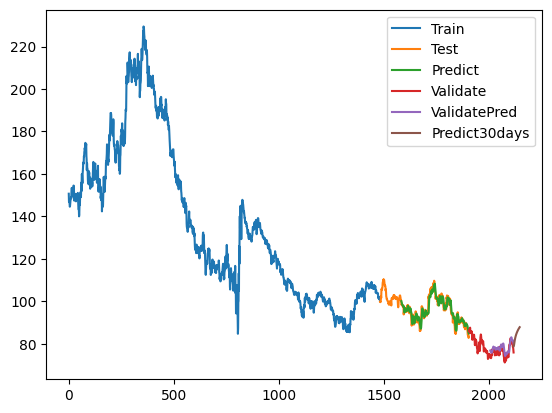

In [58]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()